# Линейные модели,случайные леса и бустинги для предсказания временных рядов.

*В рамках задачи по предсказанию индекса качества воздуха в городе Берлин были проведены эксперименты с несолькими группами данных и моделями*.<br>

Задача: прогнозировать индекс качества воздуха на некоторый период времени.<br> 
*(Индекс качества воздуха по дню считается как наибольший расчетный индекс из определенного количетсва загрязнителей.)*

Период временного ряда 2013-2020 год (подневно).

В качестве Baseline была взята взята функция предскаызвающая на ***n*** дней вперед по среднем за ***n*** дней. 

Наилучшая предыдущая модель - SARIMAX. 

MAE(среднее)  Baseline - 9.3<br>
МАЕ(среднее) SARIMAX - 8.32

# Были построены 3 типа моделей: <br>
- Линейные модели <br>
- Случайный лес <br>
- Бустинги

# Выводы по выбранным моделям:<br>
В рамках проведенных экспериментов нашей команде удалось побить ***score*** предыдущих экспериментов. <br>

Наилучшая линейная модель - Логистическая регрессия МАЕ-6.8<br>
Наилучший RF/Бустинг - XGBoost MAE-7.5  (на полных данных с дополнительными дневными признаками).<br> <br>

На основе метрик качества можно сделать вывод, что все используемые модели за исключением RandomForest приемлемы для предсказания на короткий период (до 60 дней) индекса качества воздуха.<br>

AQI варьируется от 0 до 500 значения индекса и колебания предсказаний в пределах 20 пунктов некритичны (хотя и важны).<br><br>

Задача предсказания индекса качества воздуха относительно проста. Отсутствует тренд, имеются лишь сезонные колебания (сезон года, рабочие или выходные дни).
Между значениями можно построить простую линейную зависимость.<br>

По этой причине использование сложных моделей нецелесооборазно.




# Исходные данные:

В качестве данных в различных моделях выступали : <br>
- Данные о концентрации загрязнителей в воздухе<br>
- Данные об индексах по загрязнителям (рассчитаны в соотвествии с EPA *агентство по охране окружающей среды США* на основе концентрации загрязнителей)<br>
- Расширенные данные с дополнительными  характеристиками по дням недели/года/начало_месяца/конец_месяца.<br>

In [ ]:
import pandas as pd
from fastai.tabular.core import add_datepart

In [ ]:
# Формирование датасетов
PATH = "https://raw.githubusercontent.com/dmitry-chvdr/aqi_prediction/Checkpoint4/ts_air_quality_index_2013_2020.csv"

data = pd.read_csv(PATH)
data_with_character_of_day = pd.read_csv(PATH)

# Добавим в данные привязку к дню года
add_datepart(data_with_character_of_day, "Date", drop=False)
for i in [
    "Is_month_end",
    "Is_month_start",
    "Is_quarter_end",
    "Is_quarter_start",
    "Is_year_end",
    "Is_year_start",
]:
    data_with_character_of_day[f"{i}"] = data_with_character_of_day[f"{i}"].map(
        {True: 1, False: 0}
    )

In [ ]:
# Представление данных в виде DataFrame.
data.head(3)

,CO_Concentration,NO2_Concentration,O3_Concentration,PM10_Concentration,PM2.5_Concentration,SO2_Concentration,Date,SO2_index,PM10_index,PM2.5_index,O3_index,NO2_index,CO_index,aqi
0,0.511042,30.759775,49.709444,204.521183,42.600000,13.191861,2013-01-01,7,125,118,46,15,0,125
1,0.513333,26.054568,52.687887,15.570061,25.800000,1.925773,2013-01-02,1,14,79,48,13,0,79
2,0.473333,31.372220,40.397083,13.538415,20.046667,2.064878,2013-01-03,1,12,67,37,15,0,67


In [ ]:
# Пример данных с доп. характеристикой по дню
data_with_character_of_day.head(3)

,CO_Concentration,NO2_Concentration,O3_Concentration,PM10_Concentration,PM2.5_Concentration,SO2_Concentration,Date,SO2_index,PM10_index,PM2.5_index,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0.511042,30.759775,49.709444,204.521183,42.600000,13.191861,2013-01-01,7,125,118,...,1,1,1,0,1,0,1,0,1,1.356998e+09
1,0.513333,26.054568,52.687887,15.570061,25.800000,1.925773,2013-01-02,1,14,79,...,2,2,2,0,0,0,0,0,0,1.357085e+09
2,0.473333,31.372220,40.397083,13.538415,20.046667,2.064878,2013-01-03,1,12,67,...,3,3,3,0,0,0,0,0,0,1.357171e+09


На основаниие метрик качества можно отметить, при больших наборах данных - допустимо при необходимости для ускорения расчетов выкинуть часть загрязнителей. На результатах качества это отразится, но падение ***score *** в 2 раза (Чешко Г.Д.) в данной задаче на мой взгляд допустимо в некоторых сценариях.

Были построены следующие модели:

# Линейные модели

1. Линейная регрессия.<br>
2. Линейная регрессия со сдвигом временного ряда.<br>
3. Регрессия опорных векторов.<br>
4. Логистическая регрессия.<br>

# Случайный лес и бустинги

 1. Случайный лес с учетом сезонной компоненты. (входные данные - временной ряд  ['aqi'] , ['Date'] , *дополнительный сдвиг по сезонной компоненте,логарифмирование для нормализации*.<br><br>
 2. Случайный лес без сезонной компоненты. (входные данные - временной ряд  ['aqi'] , ['Date'] .<br><br>
 3. Случайный лес обученный на части признаков с ограниченным количеством данных. (входные данные - матрица признаков [" "CO_Concentration" , "PM10_Concentration" , "PM2.5_Concentration" ] ).<br><br>
 4. Случайный лес обученный на части признаков с ограниченным количеством данных. (входные данные - матрица признаков на основе подиндексов качества воздуха  [ "CO_index" , "PM10_index" , "PM2.5_index" ]).<br><br>
 5. Обучен Бустинг (XGBoost Regressor) (входные данные - матрица признаков на основе части подиндексов качества воздуха ["CO_index" , "PM10_index" , "PM2.5_index" ].<br><br>
 6. Обучен Бустинг (XGBoost Regressor) (входные данные - матрица признаков[ "CO_Concentration" , "PM10_Concentration" , "PM2.5_Concentration" ].<br><br>
 7. Обучен Бустинг (XGBoost Regressor) (входные данные - полная матрица из подиндексов качества воздуха. ["CO_Concentration" , "PM10_Concentration" , "PM2.5_Concentration" ].<br><br>
 8. Обучен Бустинг (XGBoost Regressor) (входные данные - матрица дополненная характеристиками даты "день недели" , " день года" , "Выходной день" и прочее.

# Визуализация наилучших результатов:

Визуализация базовой модели (n дней вперед по среднем за n дней).

In [ ]:
# Визуализация предсказаний Baseline на 60 дней.

Визуализация линейных моделей:

In [ ]:
# Визуализация предсказаний линейных моделей на 60 дней.

Визуализация случайных лесов и бустингов.

In [4]:
# Визуализация предскзааний случаных лесов на 30 дней

In [ ]:
# Визуализация предсказаний бустингов на 30 дней

In [ ]:
# Дополнительно визуализируем важность признаков для 8 эксперимента (XGBoost). Данные - с дополнительными признаками по дням.
_ = xgb.plot_importance(reg, height=0.9)

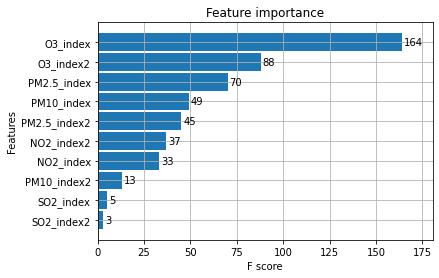

In [ ]:
# Визуализируем важость признаков для XGBoost . Полнные данные по загрязнителям.
_ = xgb.plot_importance(reg, height=0.9)

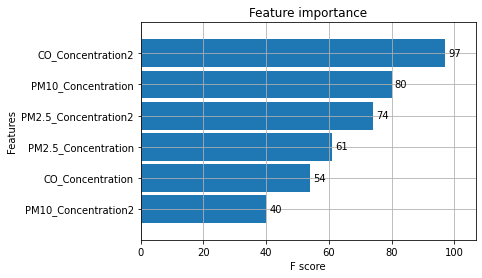

In [ ]:
# Важность признаков по ограниченным данным для XGBoost.
_ = xgb.plot_importance(reg, height=0.9)

*Загрязнителя имеющие цифру 2 в конце, показания за 2 дня до измерения.*

На основании визуализации важности признаков , можно сделать несколько выводов:
1. Озон ниболее значимый фактор при оценке качества воздуха. (в наших моделях).
2. При огранчиенной выборке загрязнителей (3 рисунок), распределение влияния/весов загрязнителей равномерно.
3. Влияние признака день года в случае его применения , достаточно высоко. С помощью, "*признаков даты*" можно более точно, предсказывать колебания индекса качества воздуха в выходые и рабочие дни, когда трафик на дорогах и выбросы от работающих предприятий оказывают наиболее неблагоприятное воздействие на атмосферу.

Влияние Озона неоднозначно. С одной стороны его высокая концентрация может быть "*маркером*" осадков, вызывающим падение уровня прочих загрязнителей (например мелкодисперсные частицы).<br>

Либо, концентрация Озона для случая его выбора как главного загрязнителя происходит так редко, что его влияние высоко (веса признака завышены).

# Метрики качества моделей.<br>
Для оценки качества построенных моделей была взята средняя абсолютная ошибка MAE.<br>
Для моделей получены следующий результаты.

# Линейные модели

1. Линейная Регрессия . МАЕ - 19.61 - для 30 дней. <br>
2. SVR Regression . MAE - 21.86 <br>
3. Логистическая регрессия. МАЕ - 6.83 <br>

# Случайные леса и бустинги

 1. Случайный лес с учетом сезонной компоненты. МАЕ=21.2<br>
 2. Случайный лес без сезонной компоненты. МАЕ=11.9 .<br>
 3. Случайный лес обученный на части признаков с ограниченным количеством данных. МАЕ=31.0<br>
 4. Случайный лес обученный на части признаков с ограниченным количеством данных. МАЕ=34.2<br>
 5. Бустинг (XGBoost Regressor)  МАЕ=16.2 (обучение на подиндексах загрязнителей)<br>
 6. Бустинг (XGBoost Regressor) МАЕ=16.1 (обучение на концентрации загрязнителей)<br>
 7. Бустинг (XGBoost Regressor) МАЕ=8.2 (обучение на полнных данных)<br>
 8. Бустинг (XGBoost Regressor)  МАЕ=7.5 (входные данные - матрица дополненная характеристиками даты).